In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import KMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#dataset

In [ ]:
train_ds = KMNIST(root='data/', train=True, download=True, transform=ToTensor())
test_ds = KMNIST(root='data/', train=False, download=True, transform=ToTensor())

  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/train-images-idx3-ubyte.gz to data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/train-labels-idx1-ubyte.gz to data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/t10k-images-idx3-ubyte.gz to data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to data/KMNIST/raw



In [ ]:
classes = train_ds.classes
n_classes = len(classes)
n_classes, classes

(10, ['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo'])

In [ ]:
len(train_ds), len(test_ds)

(60000, 10000)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
val_size = 10000
train_size = len(train_ds) - val_size

In [ ]:
train, validation = random_split(train_ds, [train_size, val_size])

In [ ]:
img, label = train[2]
img.size()

torch.Size([1, 28, 28])

In [ ]:
len(train), len(validation), len(test_ds)

(50000, 10000, 10000)

In [ ]:
train_dl = DataLoader(train, batch_size=100, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(validation, batch_size=4, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=4, num_workers=2, pin_memory=True)

torch.Size([100, 1, 28, 28])


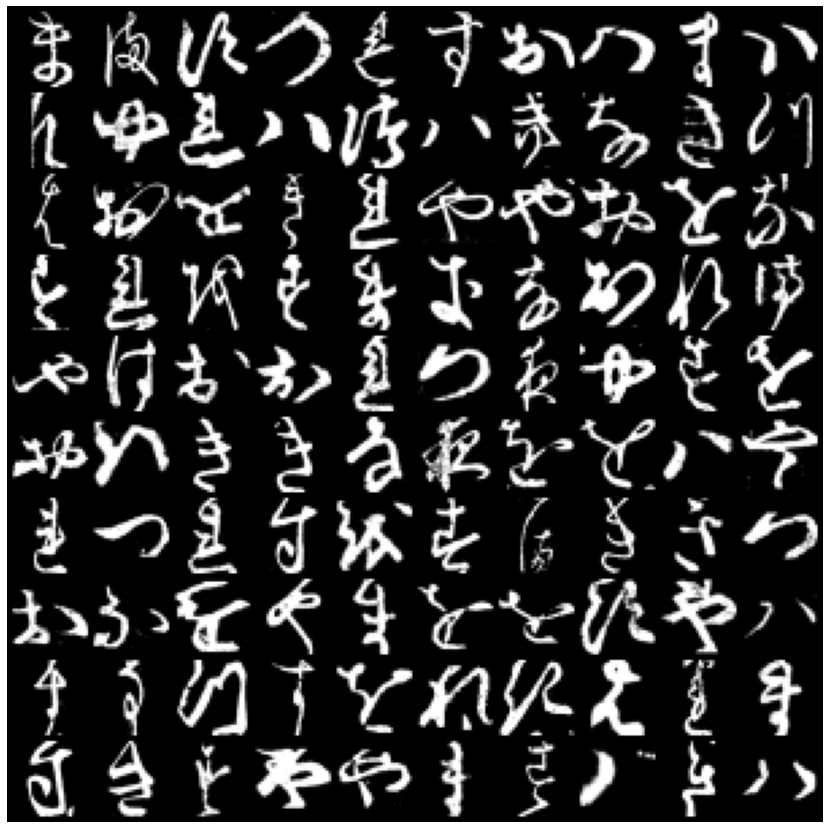

In [ ]:
for img, _ in train_dl:

  print(img.shape)
  plt.figure(figsize=(15, 15))
  plt.axis('off')
  plt.imshow(make_grid(img, nrow=10).permute(1,2,0))
  break

#base

In [ ]:
def accuracy(out, target):
  _, max_probs = torch.max(out, dim=1)
  return torch.tensor(torch.sum(max_probs == target).item() / len(max_probs))

In [ ]:
class KMNISTModelBase(nn.Module):
  def training_step(self, batch):
    xb, target = batch
    out = self(xb)
    loss = F.cross_entropy(out, target)
    return loss

  def validation_step(self, batch):
    xb, target = batch
    out = self(xb)
    val_loss = F.cross_entropy(out, target)
    val_acc = accuracy(out, target)
    return {'val_loss': val_loss, 'val_acc': val_acc}

  def validation_epoch_end(self, res):
    losses = [x['val_loss'] for x in res]
    epoch_loss = torch.stack(losses).mean()
    accs = [x['val_acc'] for x in res]
    epoch_acc = torch.stack(accs).mean()
    return {'epoch_loss': epoch_loss.detach().item(), 'epoch_acc': epoch_acc.item()}

  def epoch_end(self, epoch, res):
    print(f'Epoch [{epoch}], Validation loss: [{round(res["epoch_loss"], 4)}], Validation accuracy: [{round(res["epoch_acc"], 4)}]')

In [ ]:
def evaluate(model, val_dl):
  res = [model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(res)

In [ ]:
def fit(n_epochs, model, train_loader, val_loader, lr, opt_f=torch.optim.SGD):
  history = []
  opt = opt_f(model.parameters(), lr)

  for epoch in range(n_epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      opt.step()
      opt.zero_grad()

    res = evaluate(model, val_loader)
    history.append(res)
    model.epoch_end(epoch, res)

  return history

#to device

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
def plot_losses(history):
  losses = [x['epoch_loss'] for x in history]
  plt.figure(figsize=(20, 8))
  plt.plot(losses)
  plt.title('Loss x Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss score (cross entropy)');

In [ ]:
def plot_accs(history):
  accs = [x['epoch_acc'] for x in history]
  plt.figure(figsize=(20, 8))
  plt.plot(accs)
  plt.title('Accuracy x Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy score');

In [ ]:
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)
test_loader = DeviceDataLoader(test_dl, device)

#1

In [ ]:
for img, _ in train_dl:
  print(img.shape)
  break

torch.Size([100, 1, 28, 28])


In [ ]:
in_size = 1 * 28 * 28
in_size, n_classes

(784, 10)

In [ ]:
class kmnistModel1(KMNISTModelBase):
  def __init__(self, in_size=784, n_classes=10):
    super().__init__()
    self.linear1 = nn.Linear(in_size, 512)
    self.linear2 = nn.Linear(512, 256)
    self.linear3 = nn.Linear(256, 128)
    self.linear4 = nn.Linear(128, 64)
    self.linear5 = nn.Linear(64, 32)
    self.linear6 = nn.Linear(32, 16)
    self.linear7 = nn.Linear(16, n_classes)

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    out = F.relu(out)
    out = self.linear5(out)
    out = F.relu(out)
    out = self.linear6(out)
    out = F.relu(out)
    out = self.linear7(out)
    return out

In [ ]:
model1 = kmnistModel1()

In [ ]:
model1 = to_device(model1, device)

In [ ]:
history1 = [evaluate(model1, val_loader)]
history1

[{'epoch_acc': 0.10480000078678131, 'epoch_loss': 2.3049960136413574}]

In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.5)

Epoch [0], Validation loss: [1.6245], Validation accuracy: [0.3379]
Epoch [1], Validation loss: [0.4667], Validation accuracy: [0.875]
Epoch [2], Validation loss: [0.281], Validation accuracy: [0.9258]
Epoch [3], Validation loss: [0.3856], Validation accuracy: [0.8969]
Epoch [4], Validation loss: [0.2072], Validation accuracy: [0.9454]
Epoch [5], Validation loss: [0.1716], Validation accuracy: [0.9533]
Epoch [6], Validation loss: [0.188], Validation accuracy: [0.9534]
Epoch [7], Validation loss: [0.1848], Validation accuracy: [0.9541]
Epoch [8], Validation loss: [0.1979], Validation accuracy: [0.9474]
Epoch [9], Validation loss: [0.1826], Validation accuracy: [0.9555]


In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.4)

Epoch [0], Validation loss: [0.1815], Validation accuracy: [0.9597]
Epoch [1], Validation loss: [0.1783], Validation accuracy: [0.9605]
Epoch [2], Validation loss: [0.1918], Validation accuracy: [0.9586]
Epoch [3], Validation loss: [0.1695], Validation accuracy: [0.9632]
Epoch [4], Validation loss: [0.1759], Validation accuracy: [0.9628]
Epoch [5], Validation loss: [0.2007], Validation accuracy: [0.9611]
Epoch [6], Validation loss: [0.1909], Validation accuracy: [0.9625]
Epoch [7], Validation loss: [0.1984], Validation accuracy: [0.963]
Epoch [8], Validation loss: [0.2194], Validation accuracy: [0.9632]
Epoch [9], Validation loss: [0.1879], Validation accuracy: [0.9614]


In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.3)

Epoch [0], Validation loss: [0.1855], Validation accuracy: [0.964]
Epoch [1], Validation loss: [0.1944], Validation accuracy: [0.9653]
Epoch [2], Validation loss: [0.1991], Validation accuracy: [0.966]
Epoch [3], Validation loss: [0.1988], Validation accuracy: [0.9663]
Epoch [4], Validation loss: [0.208], Validation accuracy: [0.9657]
Epoch [5], Validation loss: [0.2117], Validation accuracy: [0.9655]
Epoch [6], Validation loss: [0.2156], Validation accuracy: [0.9661]
Epoch [7], Validation loss: [0.2152], Validation accuracy: [0.9658]
Epoch [8], Validation loss: [0.2178], Validation accuracy: [0.9664]
Epoch [9], Validation loss: [0.2262], Validation accuracy: [0.9654]


In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.2)

Epoch [0], Validation loss: [0.2229], Validation accuracy: [0.9658]
Epoch [1], Validation loss: [0.2244], Validation accuracy: [0.9654]
Epoch [2], Validation loss: [0.2263], Validation accuracy: [0.9662]
Epoch [3], Validation loss: [0.2277], Validation accuracy: [0.9657]
Epoch [4], Validation loss: [0.2296], Validation accuracy: [0.9659]
Epoch [5], Validation loss: [0.2307], Validation accuracy: [0.966]
Epoch [6], Validation loss: [0.2323], Validation accuracy: [0.9658]
Epoch [7], Validation loss: [0.2341], Validation accuracy: [0.9656]
Epoch [8], Validation loss: [0.2365], Validation accuracy: [0.9657]
Epoch [9], Validation loss: [0.2391], Validation accuracy: [0.966]


In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.1)

Epoch [0], Validation loss: [0.2401], Validation accuracy: [0.9658]
Epoch [1], Validation loss: [0.241], Validation accuracy: [0.966]
Epoch [2], Validation loss: [0.2419], Validation accuracy: [0.9658]
Epoch [3], Validation loss: [0.2429], Validation accuracy: [0.9657]
Epoch [4], Validation loss: [0.2437], Validation accuracy: [0.9656]
Epoch [5], Validation loss: [0.2447], Validation accuracy: [0.9656]
Epoch [6], Validation loss: [0.2454], Validation accuracy: [0.9656]
Epoch [7], Validation loss: [0.2462], Validation accuracy: [0.9656]
Epoch [8], Validation loss: [0.2469], Validation accuracy: [0.9657]
Epoch [9], Validation loss: [0.2477], Validation accuracy: [0.9657]


In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.05)

Epoch [0], Validation loss: [0.2481], Validation accuracy: [0.9658]
Epoch [1], Validation loss: [0.2485], Validation accuracy: [0.9658]
Epoch [2], Validation loss: [0.2488], Validation accuracy: [0.9658]
Epoch [3], Validation loss: [0.2492], Validation accuracy: [0.9658]
Epoch [4], Validation loss: [0.2496], Validation accuracy: [0.9658]
Epoch [5], Validation loss: [0.25], Validation accuracy: [0.9658]
Epoch [6], Validation loss: [0.2503], Validation accuracy: [0.9659]
Epoch [7], Validation loss: [0.2507], Validation accuracy: [0.9659]
Epoch [8], Validation loss: [0.2511], Validation accuracy: [0.9659]
Epoch [9], Validation loss: [0.2514], Validation accuracy: [0.9659]


In [ ]:
history1 += fit(10, model1, train_loader, val_loader, 0.01)

Epoch [0], Validation loss: [0.2515], Validation accuracy: [0.9659]
Epoch [1], Validation loss: [0.2516], Validation accuracy: [0.9659]
Epoch [2], Validation loss: [0.2516], Validation accuracy: [0.9659]
Epoch [3], Validation loss: [0.2517], Validation accuracy: [0.9659]
Epoch [4], Validation loss: [0.2518], Validation accuracy: [0.9659]
Epoch [5], Validation loss: [0.2518], Validation accuracy: [0.9659]
Epoch [6], Validation loss: [0.2519], Validation accuracy: [0.9659]
Epoch [7], Validation loss: [0.252], Validation accuracy: [0.9659]
Epoch [8], Validation loss: [0.2521], Validation accuracy: [0.9659]
Epoch [9], Validation loss: [0.2521], Validation accuracy: [0.9659]


In [ ]:
history1 += fit(5, model1, train_loader, val_loader, 0.001)

Epoch [0], Validation loss: [0.2521], Validation accuracy: [0.9659]
Epoch [1], Validation loss: [0.2521], Validation accuracy: [0.9659]
Epoch [2], Validation loss: [0.2521], Validation accuracy: [0.9659]
Epoch [3], Validation loss: [0.2521], Validation accuracy: [0.9659]
Epoch [4], Validation loss: [0.2522], Validation accuracy: [0.9659]


In [ ]:
history1 += fit(5, model1, train_loader, val_loader, 0.0001)

Epoch [0], Validation loss: [0.2522], Validation accuracy: [0.9659]
Epoch [1], Validation loss: [0.2522], Validation accuracy: [0.9659]
Epoch [2], Validation loss: [0.2522], Validation accuracy: [0.9659]
Epoch [3], Validation loss: [0.2522], Validation accuracy: [0.9659]
Epoch [4], Validation loss: [0.2522], Validation accuracy: [0.9659]


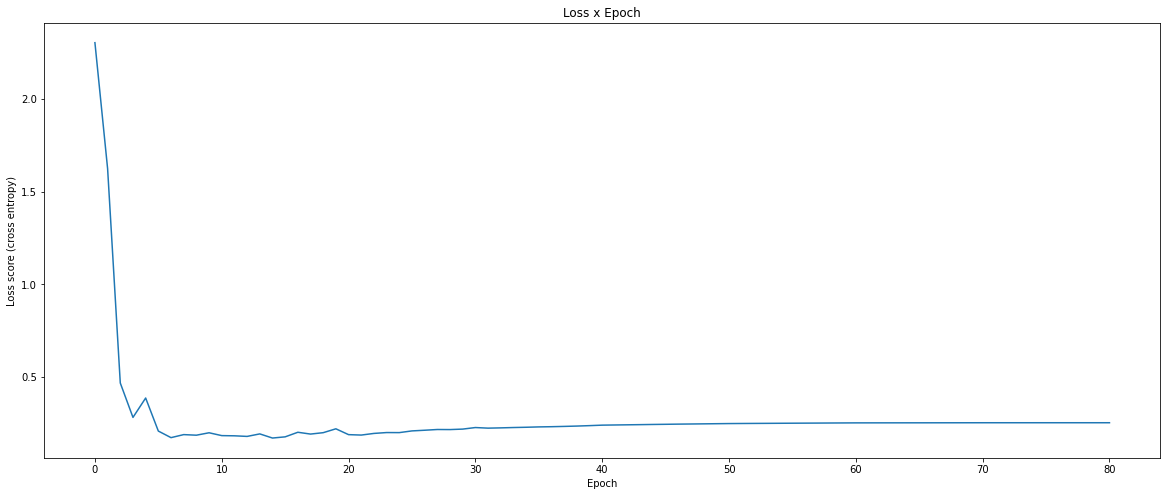

In [ ]:
plot_losses(history1)

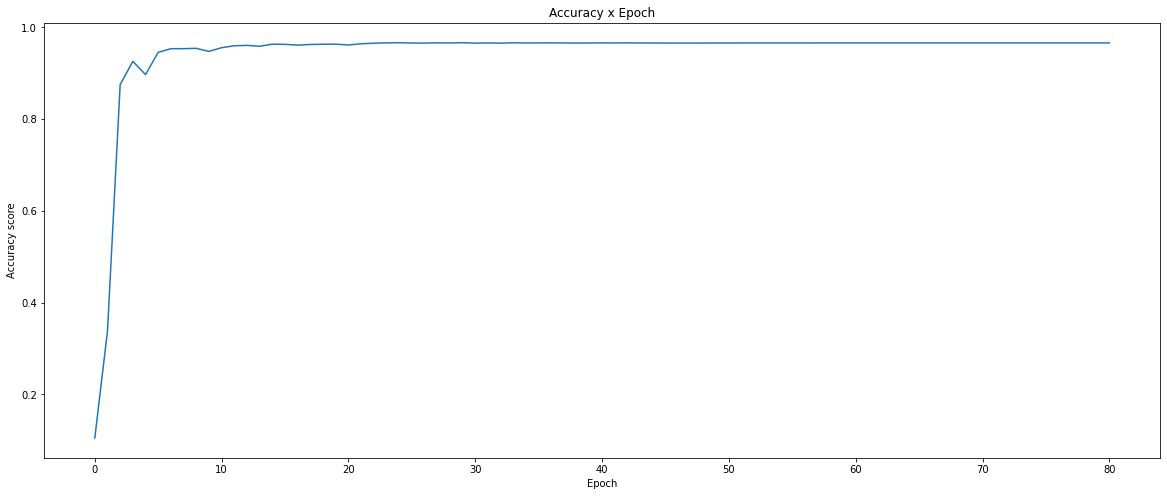

In [ ]:
plot_accs(history1)

#2

In [ ]:
_ = 3
_3 = []
while _ < 784:
  _3.append(_)
  _ = _ * 3
_3

[3, 9, 27, 81, 243, 729]

In [ ]:
class kmnistModel2(KMNISTModelBase):
  def __init__(self, in_size=784, n_classes=10):
    super().__init__()
    self.linear1 = nn.Linear(in_size, 243)
    self.linear2 = nn.Linear(243, 81)
    self.linear3 = nn.Linear(81, 27)
    self.linear4 = nn.Linear(27, n_classes)

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    return out

In [ ]:
model2 = kmnistModel2()

In [ ]:
model2 = to_device(model2, device)

In [ ]:
history2 = [evaluate(model2, val_loader)]

In [ ]:
history2 += fit(10, model2, train_loader, val_loader, 0.5)

Epoch [0], Validation loss: [0.2823], Validation accuracy: [0.9124]
Epoch [1], Validation loss: [0.2067], Validation accuracy: [0.9372]
Epoch [2], Validation loss: [0.1694], Validation accuracy: [0.9483]
Epoch [3], Validation loss: [0.2034], Validation accuracy: [0.9408]
Epoch [4], Validation loss: [0.1703], Validation accuracy: [0.9525]
Epoch [5], Validation loss: [0.1594], Validation accuracy: [0.9567]
Epoch [6], Validation loss: [0.2187], Validation accuracy: [0.945]
Epoch [7], Validation loss: [0.1845], Validation accuracy: [0.9559]
Epoch [8], Validation loss: [0.1771], Validation accuracy: [0.9585]
Epoch [9], Validation loss: [0.245], Validation accuracy: [0.9459]


In [ ]:
history2 += fit(10, model2, train_loader, val_loader, 0.4)

Epoch [0], Validation loss: [0.192], Validation accuracy: [0.9598]
Epoch [1], Validation loss: [0.2015], Validation accuracy: [0.9596]
Epoch [2], Validation loss: [0.1918], Validation accuracy: [0.9628]
Epoch [3], Validation loss: [0.1955], Validation accuracy: [0.965]
Epoch [4], Validation loss: [0.2002], Validation accuracy: [0.9647]
Epoch [5], Validation loss: [0.2042], Validation accuracy: [0.9643]
Epoch [6], Validation loss: [0.2067], Validation accuracy: [0.964]
Epoch [7], Validation loss: [0.2108], Validation accuracy: [0.964]
Epoch [8], Validation loss: [0.2123], Validation accuracy: [0.9642]
Epoch [9], Validation loss: [0.2143], Validation accuracy: [0.964]


In [ ]:
history2 += fit(10, model2, train_loader, val_loader, 0.3)

Epoch [0], Validation loss: [0.2158], Validation accuracy: [0.9638]
Epoch [1], Validation loss: [0.2173], Validation accuracy: [0.9637]
Epoch [2], Validation loss: [0.2185], Validation accuracy: [0.9636]
Epoch [3], Validation loss: [0.2199], Validation accuracy: [0.9636]
Epoch [4], Validation loss: [0.2211], Validation accuracy: [0.9639]
Epoch [5], Validation loss: [0.2222], Validation accuracy: [0.9638]
Epoch [6], Validation loss: [0.2233], Validation accuracy: [0.9638]
Epoch [7], Validation loss: [0.2246], Validation accuracy: [0.9642]
Epoch [8], Validation loss: [0.2254], Validation accuracy: [0.9641]
Epoch [9], Validation loss: [0.2265], Validation accuracy: [0.9641]


In [ ]:
history2 += fit(10, model2, train_loader, val_loader, 0.2)

Epoch [0], Validation loss: [0.2271], Validation accuracy: [0.9641]
Epoch [1], Validation loss: [0.2276], Validation accuracy: [0.9642]
Epoch [2], Validation loss: [0.2283], Validation accuracy: [0.9642]
Epoch [3], Validation loss: [0.2289], Validation accuracy: [0.9641]
Epoch [4], Validation loss: [0.2295], Validation accuracy: [0.9641]
Epoch [5], Validation loss: [0.2301], Validation accuracy: [0.9642]
Epoch [6], Validation loss: [0.2306], Validation accuracy: [0.964]
Epoch [7], Validation loss: [0.2311], Validation accuracy: [0.9641]
Epoch [8], Validation loss: [0.2316], Validation accuracy: [0.9641]
Epoch [9], Validation loss: [0.2322], Validation accuracy: [0.9641]


In [ ]:
history2 += fit(10, model2, train_loader, val_loader, 0.1)

Epoch [0], Validation loss: [0.2325], Validation accuracy: [0.9641]
Epoch [1], Validation loss: [0.2327], Validation accuracy: [0.9641]
Epoch [2], Validation loss: [0.233], Validation accuracy: [0.9641]
Epoch [3], Validation loss: [0.2332], Validation accuracy: [0.9641]
Epoch [4], Validation loss: [0.2335], Validation accuracy: [0.9641]
Epoch [5], Validation loss: [0.2337], Validation accuracy: [0.9641]
Epoch [6], Validation loss: [0.2339], Validation accuracy: [0.964]
Epoch [7], Validation loss: [0.2342], Validation accuracy: [0.964]
Epoch [8], Validation loss: [0.2344], Validation accuracy: [0.964]
Epoch [9], Validation loss: [0.2346], Validation accuracy: [0.964]


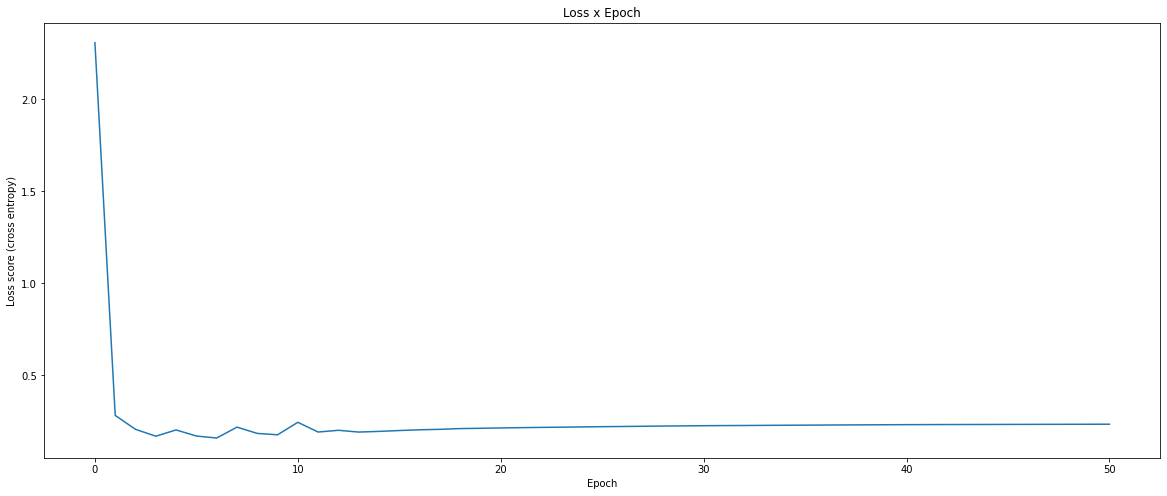

In [ ]:
plot_losses(history2)

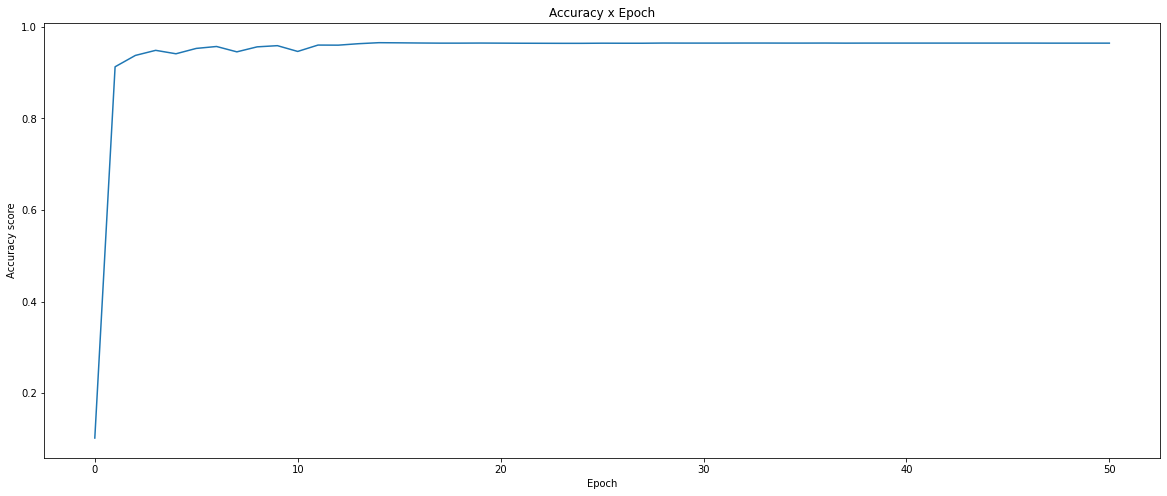

In [ ]:
plot_accs(history2)

#3

In [ ]:
class kmnistModel3(KMNISTModelBase):
  def __init__(self, in_size=784, n_classes=10):
    super().__init__()
    self.linear1 = nn.Linear(in_size, 256)
    self.linear2 = nn.Linear(256, 128)
    self.linear3 = nn.Linear(128, n_classes)

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    return out

In [ ]:
model3 = kmnistModel3()

In [ ]:
model3 = to_device(model3, device)

In [ ]:
history3 = [evaluate(model3, val_loader)]
history3

[{'epoch_acc': 0.10490000247955322, 'epoch_loss': 2.3052353858947754}]

In [ ]:
history3 += fit(10, model3, train_loader, val_loader, 0.5)

Epoch [0], Validation loss: [0.2317], Validation accuracy: [0.9287]
Epoch [1], Validation loss: [0.2009], Validation accuracy: [0.9387]
Epoch [2], Validation loss: [0.1815], Validation accuracy: [0.9442]
Epoch [3], Validation loss: [0.179], Validation accuracy: [0.9488]
Epoch [4], Validation loss: [0.18], Validation accuracy: [0.95]
Epoch [5], Validation loss: [0.1555], Validation accuracy: [0.9556]
Epoch [6], Validation loss: [0.1645], Validation accuracy: [0.9594]
Epoch [7], Validation loss: [0.167], Validation accuracy: [0.9568]
Epoch [8], Validation loss: [0.164], Validation accuracy: [0.9613]
Epoch [9], Validation loss: [0.1665], Validation accuracy: [0.9613]


In [ ]:
history3 += fit(10, model3, train_loader, val_loader, 0.4)

Epoch [0], Validation loss: [0.1652], Validation accuracy: [0.9642]
Epoch [1], Validation loss: [0.1694], Validation accuracy: [0.964]
Epoch [2], Validation loss: [0.1729], Validation accuracy: [0.9637]
Epoch [3], Validation loss: [0.1742], Validation accuracy: [0.9639]
Epoch [4], Validation loss: [0.1782], Validation accuracy: [0.9639]
Epoch [5], Validation loss: [0.1793], Validation accuracy: [0.9639]
Epoch [6], Validation loss: [0.1811], Validation accuracy: [0.9642]
Epoch [7], Validation loss: [0.1827], Validation accuracy: [0.964]
Epoch [8], Validation loss: [0.1842], Validation accuracy: [0.9643]
Epoch [9], Validation loss: [0.1852], Validation accuracy: [0.9642]


In [ ]:
history3 += fit(10, model3, train_loader, val_loader, 0.3)

Epoch [0], Validation loss: [0.1865], Validation accuracy: [0.9643]
Epoch [1], Validation loss: [0.1873], Validation accuracy: [0.9639]
Epoch [2], Validation loss: [0.188], Validation accuracy: [0.9642]
Epoch [3], Validation loss: [0.1889], Validation accuracy: [0.9643]
Epoch [4], Validation loss: [0.1897], Validation accuracy: [0.9644]
Epoch [5], Validation loss: [0.1907], Validation accuracy: [0.9642]
Epoch [6], Validation loss: [0.1912], Validation accuracy: [0.9644]
Epoch [7], Validation loss: [0.1919], Validation accuracy: [0.9644]
Epoch [8], Validation loss: [0.1924], Validation accuracy: [0.9641]
Epoch [9], Validation loss: [0.1932], Validation accuracy: [0.9641]


In [ ]:
history3 += fit(10, model3, train_loader, val_loader, 0.2)

Epoch [0], Validation loss: [0.1935], Validation accuracy: [0.9641]
Epoch [1], Validation loss: [0.1939], Validation accuracy: [0.9643]
Epoch [2], Validation loss: [0.1944], Validation accuracy: [0.9643]
Epoch [3], Validation loss: [0.1951], Validation accuracy: [0.9641]
Epoch [4], Validation loss: [0.195], Validation accuracy: [0.9641]
Epoch [5], Validation loss: [0.1956], Validation accuracy: [0.9643]
Epoch [6], Validation loss: [0.1959], Validation accuracy: [0.9644]
Epoch [7], Validation loss: [0.1961], Validation accuracy: [0.9645]
Epoch [8], Validation loss: [0.1965], Validation accuracy: [0.9644]
Epoch [9], Validation loss: [0.1969], Validation accuracy: [0.9645]


In [ ]:
history3 += fit(10, model3, train_loader, val_loader, 0.1)

Epoch [0], Validation loss: [0.197], Validation accuracy: [0.9644]
Epoch [1], Validation loss: [0.1973], Validation accuracy: [0.9643]
Epoch [2], Validation loss: [0.1975], Validation accuracy: [0.9643]
Epoch [3], Validation loss: [0.1976], Validation accuracy: [0.9643]
Epoch [4], Validation loss: [0.1978], Validation accuracy: [0.9643]
Epoch [5], Validation loss: [0.198], Validation accuracy: [0.9642]
Epoch [6], Validation loss: [0.1981], Validation accuracy: [0.9645]
Epoch [7], Validation loss: [0.1982], Validation accuracy: [0.9644]
Epoch [8], Validation loss: [0.1984], Validation accuracy: [0.9642]
Epoch [9], Validation loss: [0.1987], Validation accuracy: [0.9643]


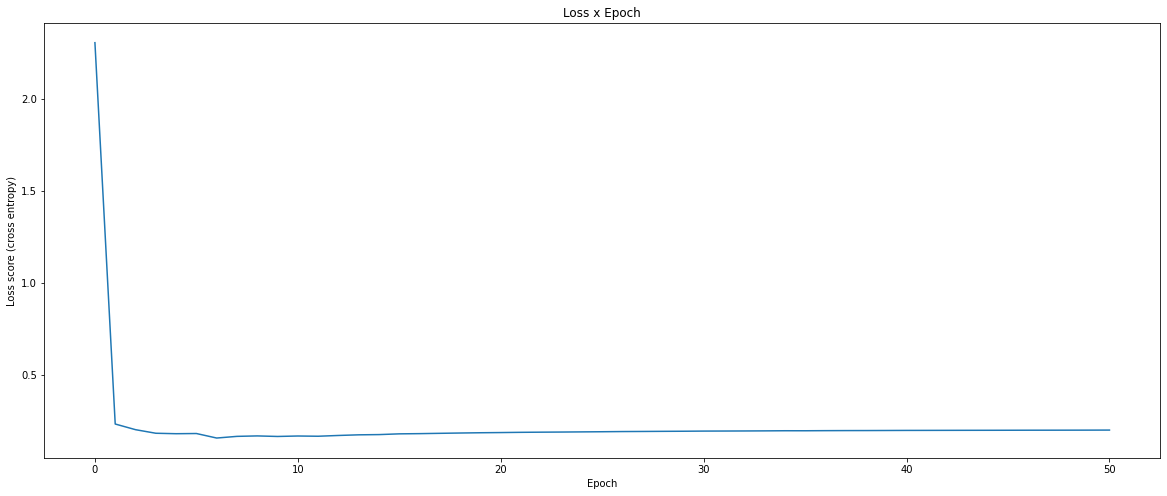

In [ ]:
plot_losses(history3)

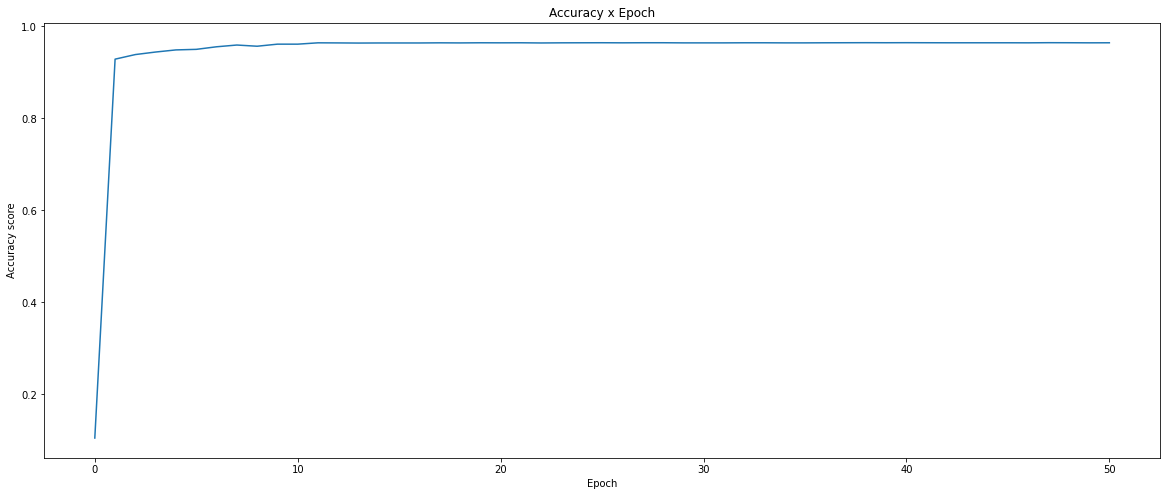

In [ ]:
plot_accs(history3)

#Eval

In [ ]:
model1_metrics = [evaluate(model1, test_loader)]
model2_metrics = [evaluate(model2, test_loader)]
model3_metrics = [evaluate(model3, test_loader)]

In [ ]:
print(f'Model 1 test evaluation: {model1_metrics}')
print(f'Model 2 test evaluation: {model2_metrics}')
print(f'Model 3 test evaluation: {model3_metrics}')

Model 1 test evaluation: [{'epoch_loss': 0.695855438709259, 'epoch_acc': 0.9204000234603882}]
Model 2 test evaluation: [{'epoch_loss': 0.6669427752494812, 'epoch_acc': 0.9140999913215637}]
Model 3 test evaluation: [{'epoch_loss': 0.5643250346183777, 'epoch_acc': 0.9136000275611877}]


In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 6 , Predicted: 6
Label: ma , Predicted: ma


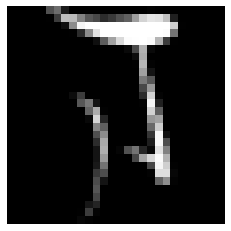

In [ ]:
img, label = test_ds[1324]
plt.imshow(img[0], cmap='gray')
plt.axis('off')
print('Label:', label, ', Predicted:', predict_image(img, model2))
print('Label:', classes[label], ', Predicted:', classes[predict_image(img, model2)])

In [ ]:
torch.save(model1.state_dict(), 'kmnist1.sth')
torch.save(model2.state_dict(), 'kmnist2.sth')
torch.save(model3.state_dict(), 'kmnist3.sth')

In [ ]:
#!mkdir '/content/drive/MyDrive/kaggle competitions/kmnist'
%cd '/content/drive/MyDrive/kaggle competitions/kmnist'

mkdir: cannot create directory ‘/content/drive/MyDrive/kaggle competitions/kmnist’: File exists
/content/drive/MyDrive/kaggle competitions/kmnist


In [ ]:
!cp /content/kmnist1.sth '/content/drive/MyDrive/kaggle competitions/kmnist'
!cp /content/kmnist2.sth '/content/drive/MyDrive/kaggle competitions/kmnist'
!cp /content/kmnist3.sth '/content/drive/MyDrive/kaggle competitions/kmnist'